In [297]:
import numpy as np
import scipy
inv = np.linalg.inv
import matplotlib.pyplot as plt
import sklearn

In [29]:
def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

In [45]:


class Offline_LDA_old:
    """
    Parameters:
    ====================
    K             -- Dimension of PCA subspace to learn
    D             -- Dimensionality of data
    M0            -- Initial guess for the lateral weight matrix M, must be of size K-by-K
    W0            -- Initial guess for the forward weight matrix W, must be of size K-by-D
    learning_rate -- Learning rate as a function of t
    tau           -- Learning rate factor for M (multiplier of the W learning rate)
    Methods:
    ========
    fit()
    """

    def __init__(self, K, D, N, M0=None, W0=None, learning_rate=eta, tau=0.5):

        if M0 is not None:
            assert M0.shape == (K, K), "The shape of the initial guess Minv0 must be (K,K)=(%d,%d)" % (K, K)
            M = M0
        else:
            M = np.eye(K)

        if W0 is not None:
            assert W0.shape == (K, D), "The shape of the initial guess W0 must be (K,D)=(%d,%d)" % (K, D)
            W = W0
        else:
            W = np.random.normal(0, 1.0 / np.sqrt(D), size=(K, D))


        self.eta = learning_rate
        self.t = 0

        self.K = K
        self.D = D
        self.N = N
        self.tau = tau
        self.M = M
        self.W = W

    def fit(self, X, q, SW):

        assert X.shape == (self.D, self.N)

        t, tau, W, M, K, N = self.t, self.tau, self.W, self.M, self.K, self.N


        MW = np.dot(np.linalg.inv(M), W)
        input = np.dot(X, q)
        input = input.reshape(input.shape[0], 1)
        Y = np.dot(MW, input)
        Y = Y.reshape(Y.shape[0], 1)
        
        
        step = self.eta(t)

        
        outer_W = np.dot(2 * step *  Y, input.T).dot(np.linalg.inv(SW))
        W = (1 - 2 * step) * W + outer_W
        
        step = step / tau
        outer_M = np.dot(step * Y, Y.T)
        M = (1 - step) * M + outer_M

        self.M = M
        self.W = W

        self.t += 1 

In [31]:
class Offline_LDA:
    """
    Parameters:
    ====================
    K             -- Dimension of PCA subspace to learn
    D             -- Dimensionality of data
    M0            -- Initial guess for the lateral weight matrix M, must be of size K-by-K
    W0            -- Initial guess for the forward weight matrix W, must be of size K-by-D
    learning_rate -- Learning rate as a function of t
    tau           -- Learning rate factor for M (multiplier of the W learning rate)
    Methods:
    ========
    fit_next()
    """

    def __init__(self, K, D, tau=0.5):

        

        self.eta = eta
        self.gamma = gamma
        self.t = 0
        
        
        self.w = np.random.normal(0, 1.0 / np.sqrt(D), size=(D, K))
        self.l = np.random.normal(0, 1)
        
        
        
        self.K = K
        self.D = D
        self.tau = tau

    def fit(self, mu1, mu2, SW):

        t, tau, w, l, K = self.t, self.tau, self.w, self.l, self.K

        if len(mu1.shape) != 2:
            mu1 = np.expand_dims(mu1, axis=-1)
        if len(mu2.shape) != 2:
            mu2 = np.expand_dims(mu2, axis=-1)
        
        assert mu1.shape[1] == 1
        assert mu2.shape[1] == 1
        
        e_step = self.eta(t)
        g_step = self.gamma(t)
        w = w + e_step * (mu1 - mu2 - l * (SW@w))
        l = l + g_step * (w.T@SW@w -1)
        
        self.w = w
        self.l = l
        self.t += 1
        

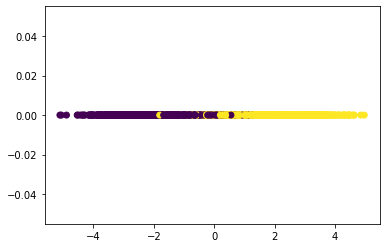

In [139]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X,y)
y_ = clf.transform(X)
plt.scatter( y_,np.zeros(y_.shape), c = y)
plt.show()
true_lda_score = max((np.sum(y_[y == 1] > 0) + np.sum(y_[y == 0] < 0)), (np.sum(y_[y == 0] > 0) + np.sum(y_[y == 1] < 0)) )/10000

In [156]:
def eta(t):
    """
    Parameters:
    ====================
    t -- time at which learning rate is to be evaluated
    Output:
    ====================
    step -- learning rate at time t
    """

    return 1 / (t + 5)

def gamma(t):
    """
    Parameters:
    ====================
    t -- time at which learning rate is to be evaluated
    Output:
    ====================
    step -- learning rate at time t
    """

    return 1/ (t + 20)

In [445]:
X, y = make_classification(n_samples=10000, n_features=500,class_sep=10, n_clusters_per_class=1, n_classes=2)

X1 = X[y == 0]
X2 = X[y == 1]
mean1 = X1.mean(0)
mean2 = X2.mean(0)
mean_diff = np.atleast_1d(mean1 - mean2)
cov1 = calculate_covariance_matrix(X1)
cov2 = calculate_covariance_matrix(X2)
cov_tot = cov1 + cov2

In [448]:
LDA = Offline_LDA(1, 500)
n_epoch = 50
err = []
for n_e in range(n_epoch):
    LDA.fit(mean1, mean2, cov_tot)
    Y = LDA.w.T.dot(X.T)
    err.append(true_lda_score - max((np.sum(Y[:,y == 1] > 0) + np.sum(Y[:,y == 0] < 0)), (np.sum(Y[:,y == 0] > 0) + np.sum(Y[:,y == 1] < 0)) )/10000)

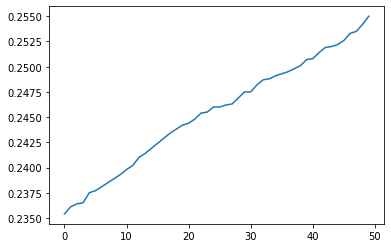

In [449]:
plt.plot(err)
plt.show()

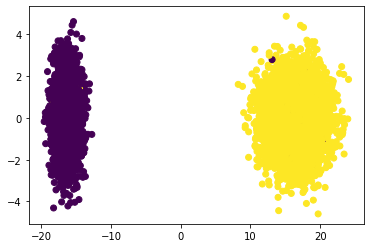

In [441]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_X = pca.fit_transform(X)
plt.scatter(PCA_X[:,0], PCA_X[:,1], c = y)
plt.show()

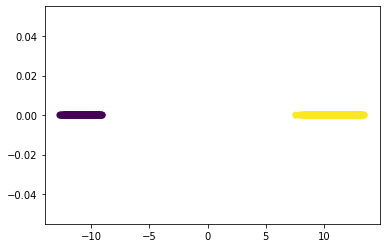

In [447]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
PCA_1X = pca.fit_transform(X)
plt.scatter(PCA_1X, np.zeros(PCA_1X.shape), c = y)
plt.show()

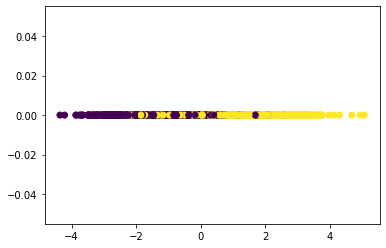

In [450]:
Y = LDA.w.T.dot(X.T)
plt.scatter(Y,np.zeros(Y.shape), c = y)
plt.show()

In [444]:
max((np.sum(Y[:,y == 1] > 0) + np.sum(Y[:,y == 0] < 0)), (np.sum(Y[:,y == 0] > 0) + np.sum(Y[:,y == 1] < 0)) )/10000
    

0.5375

In [451]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X,y)

LinearDiscriminantAnalysis()

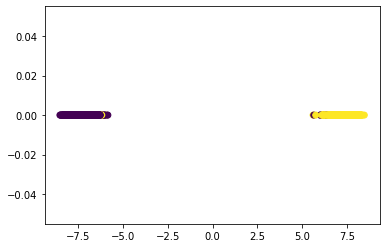

In [452]:
y_ = clf.transform(X)
plt.scatter( y_,np.zeros(y_.shape), c = y)
plt.show()

In [149]:
true_lda_score = max((np.sum(y_[y == 1] > 0) + np.sum(y_[y == 0] < 0)), (np.sum(y_[y == 0] > 0) + np.sum(y_[y == 1] < 0)) )/10000
    

In [150]:
true_lda_score

0.9148

In [348]:
class Online_LDA:
    """
    Parameters:
    ====================
    K             -- Dimension of PCA subspace to learn
    D             -- Dimensionality of data
    M0            -- Initial guess for the lateral weight matrix M, must be of size K-by-K
    W0            -- Initial guess for the forward weight matrix W, must be of size K-by-D
    learning_rate -- Learning rate as a function of t
    tau           -- Learning rate factor for M (multiplier of the W learning rate)
    Methods:
    ========
    fit_next()
    """

    def __init__(self, K, D, tau=0.5):

        

        self.eta = eta
        self.gamma = gamma
        self.t = 1
        
        self.a = 1/2
        self.b = 1/2
        
        self.w = np.random.normal(0, 1.0, size=(D,))
        self.l = np.random.normal(0, 1.0)

        self.ybar = 0
        self.xbar = 0
        
        self.K = K
        self.D = D
        self.tau = tau

    def fit_next(self, x, r, s):

        assert x.shape == (self.D,)
        

        t, tau, w, l = self.t, self.tau, self.w, self.l
        ybar, xbar = self.ybar, self.xbar
        a, b = self.a, self.b
        
        y = (w.T@x).item()
        ybar = ybar + (1/t)*(y-ybar)
        yhat = y - ybar
        
        xbar = xbar +(1/t)*(x-xbar)
        a = a + (1/t)*(r-a)
        b = b + (1/t)*(s-b)
    
        
        r_a = r/a if a != 0 else 0
        s_b = s/b if b != 0 else 0
        
        e_step = self.eta(t)
        g_step = self.gamma(t)
        
    
        w =  w + e_step*(r_a-s_b-l*yhat)*x + e_step*(l*yhat*xbar)
        
        
        l = l + g_step*(yhat*yhat-1)
        
        
        
        self.ybar = ybar
        self.xbar = xbar
        self.a = a
        self.b = b
        self.w = w
        self.l = l
        self.t += 1
        

In [202]:
from sklearn.datasets import make_classification

# other options are also available
X, y = make_classification(n_samples=10000, n_features=500,class_sep=2, n_clusters_per_class=1, n_classes=2)

X1 = X[y == 0]
X2 = X[y == 1]
mean1 = X1.mean(0)
mean2 = X2.mean(0)
mean_diff = np.atleast_1d(mean1 - mean2)
cov1 = calculate_covariance_matrix(X1)
cov2 = calculate_covariance_matrix(X2)
cov_tot = cov1 + cov2


SW = cov_tot

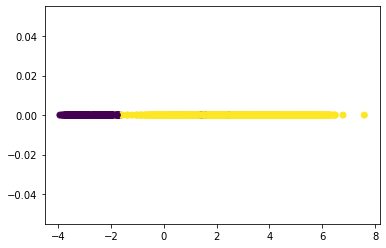

In [203]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X,y)
y_ = clf.transform(X)
plt.scatter( y_,np.zeros(y_.shape), c = y)
plt.show()
true_lda_score = max((np.sum(y_[y == 1] > 0) + np.sum(y_[y == 0] < 0)), (np.sum(y_[y == 0] > 0) + np.sum(y_[y == 1] < 0)) )/10000

In [409]:
def eta(t):
    """
    Parameters:
    ====================
    t -- time at which learning rate is to be evaluated
    Output:
    ====================
    step -- learning rate at time t
    """

    return 5e-6

def gamma(t):
    """
    Parameters:
    ====================
    t -- time at which learning rate is to be evaluated
    Output:
    ====================
    step -- learning rate at time t
    """

    return 5e-6

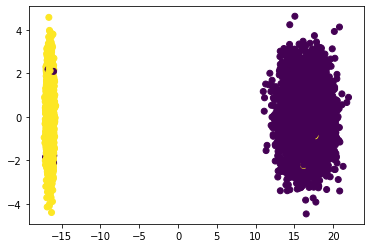

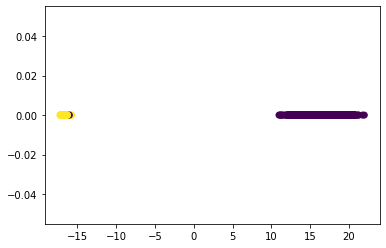

0.03170000000000006


In [416]:
from sklearn.datasets import make_classification

errs = []

LDAs = []
for i in range(1):
    
    X, y = make_classification(n_samples=10000, n_features=500,class_sep=10, n_clusters_per_class=1, n_classes=2)

    X1 = X[y == 0]
    X2 = X[y == 1]
    mean1 = X1.mean(0)
    mean2 = X2.mean(0)
    mean_diff = np.atleast_1d(mean1 - mean2)
    cov1 = calculate_covariance_matrix(X1)
    cov2 = calculate_covariance_matrix(X2)
    cov_tot = cov1 + cov2

    """
    mean1 =  np.zeros(500)
    #cov1 = sklearn.datasets.make_spd_matrix(500)
    X1 = np.random.multivariate_normal(mean1, cov1, 5000)
    mean2 =  np.zeros(500) + 0.5
    #cov2 = sklearn.datasets.make_spd_matrix(500)
    X2 = np.random.multivariate_normal(mean2, cov2, 5000)
    

    X = np.concatenate((X1,X2))
    y = np.zeros(10000)
    y[5000:] = 1

    idx = np.random.permutation(len(X))
    X, y  = X[idx], y[idx]

    """
    
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    PCA_X = pca.fit_transform(X)
    plt.scatter(PCA_X[:,0], PCA_X[:,1], c = y)
    plt.show()

    pca = PCA(n_components=1)
    PCA_1X = pca.fit_transform(X)
    plt.scatter(PCA_1X, np.zeros(PCA_1X.shape), c = y)
    plt.show()
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(X,y)
    y_ = clf.transform(X)
    true_lda_score = max((np.sum(y_[y == 1] > 0) + np.sum(y_[y == 0] < 0)), (np.sum(y_[y == 0] > 0) + np.sum(y_[y == 1] < 0)) )/10000
    
    LDA = Online_LDA(1, 500)

    n_epoch = 25
    err = []

    for n_e in range(n_epoch):
        for count, x in enumerate(X):
            if y[count] == 0:
                r = 1
                s = 0
            else:
                r = 0
                s = 1
            LDA.fit_next(x, r, s)
        Y = LDA.w.T.dot(X.T)
        err.append(true_lda_score - max((np.sum(Y[y == 1] > 0) + np.sum(Y[y == 0] < 0)), (np.sum(Y[y == 0] > 0) + np.sum(Y[y == 1] < 0)) )/10000)
    
    print(err[-1])
    errs.append(err[-1])
    LDAs.append(LDA)

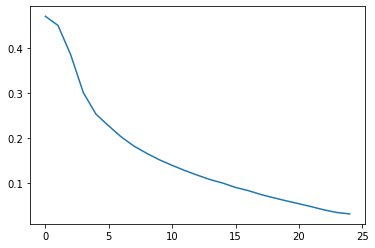

In [417]:
plt.plot(err)
plt.show()

In [418]:
Y = LDA.w.T.dot(X.T)
max((np.sum(Y[y == 1] > 0) + np.sum(Y[y == 0] < 0)), (np.sum(Y[y == 0] > 0) + np.sum(Y[y == 1] < 0)) )/10000

0.9638

In [419]:
true_lda_score

0.9955

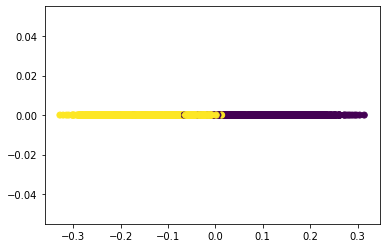

In [422]:
plt.scatter(Y,np.zeros(Y.shape), c = y)
plt.show()

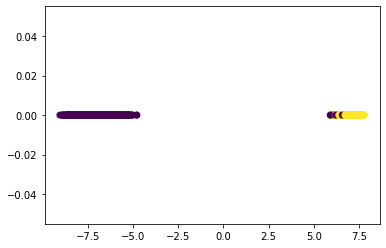

In [423]:
plt.scatter( y_,np.zeros(y_.shape), c = y)
plt.show()